In [13]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import torch
from tqdm import tqdm 
from torch import nn
from torch.optim import Adam
from scipy.special import gammaln

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from numpy.lib.stride_tricks import sliding_window_view
from models.last_layer_models import LLI, train_last_layer_det, LastLayerVIClosedForm
from utils.data_utils import create_synthetic_train_data
from models.vi import run_last_layer_vi_closed_form


np.random.seed(100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# VI with a Gausian var. distribution \& closed form ELBO

We want to approximate the posterior of the following model
\begin{align}
y = w^T \psi(x) + \varepsilon, \qquad \varepsilon \sim \mathcal{N}(0, \sigma_{\varepsilon}^2), \qquad w \sim \mathcal{N}(0, \tau^2I)
\end{align}
where we assume $\sigma_{\varepsilon}$ and $\tau^2$ to be fixed and known. We have a standard normal prior on the last-layer weights.
In this case we can write the ELBO in closed-form as 

\begin{align*}
        \text{ELBO}(\lambda) = \textcolor{purple}{E_{q_(\lambda)}[\log p(y \mid x, w)]} - \textcolor{green}{KL( q_{\lambda}(w) || p(w))} = \textcolor{purple}{\log \phi_1(y ; \mu_{w}^T \psi , \sigma_{\varepsilon}^2) - \frac{1}{2}\sigma_{\varepsilon}^{-2} \psi^T \Sigma_w \psi}  - \textcolor{green}{KL( q_{\lambda}(w) || p(w))},
\end{align*}

where $\textcolor{purple}{q_{\lambda}(w) = \phi_1(w; \mu_w, \Sigma_w)}$. We have a variational distribution with a full covariance matrix.\
For new observations we can obtain the predictive posterior distribution conditional on the parameters $\mu_w, \tau^2$
\begin{align}
p(y | x, \mu_w, \tau^2) = \mathcal{N}(\mu_w^T\psi, \psi^T \Sigma_w \psi + \sigma_{\varepsilon}^2I).
\end{align}

## 1. Data
First, we set up a synthetic dataset using a noisy sine function, where $y = \sin(x) + \varepsilon$ where $\varepsilon \sim \mathcal{N}(0, \sigma_{\varepsilon}^2)$.

In [7]:
sigma_eps = 0.3
xs, ys, xs_train, ys_train, xs_val, ys_val = create_synthetic_train_data(xs_range = [-4,4], num_points = 200,  sigma_eps = sigma_eps)
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

## 2. Model
We use a dense, feedforward neural network with ReLU activations in all but the output layer.

In [14]:
# all models have 4 layers with 100, 100, 5 and 1 neuron(s), respectively.
model_dims = [1, 100, 100, 100, 10, 1]
num_epochs = 100

# initialize model
lli_net = LLI(model_dims)
    
# train model
model, losses_train, losses_val = train_last_layer_det(model = lli_net, dataloader_train = dataloader_train,
                     dataloader_val= dataloader_train, weight_decay = 0, num_epochs = 100)

# freeze weights after training
for param in lli_net.parameters():
    param.requires_grad = False

# get last-layer embeddings psi
with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)

100%|██████████| 100/100 [00:00<00:00, 141.01it/s]


## 3. Run VI with closed-form ELBO
We now run VI with the closed-form ELBO objective from above. Because the objective is available in closed-form, we don't have to draw samples from $q_{\lambda}$.
In each VI iteration, we
1. Compute $\hat{y}$ based on the current variational parameters
2. Compute the exp. log-likelihood $\textcolor{purple}{E_{q_(\lambda)}[\log p(y \mid x, w)]}$ and KL term $\textcolor{green}{KL( q_{\lambda}(w) || p(w))}$ for the ELBO.
3. Update the variational parameters to maximize the ELBO $\lambda^{[t + 1]} = \lambda^{[t]} - \nabla_{\lambda}\text{ELBO}(\lambda)$.

We set the prior variance for $w$ as $\tau^2 = 1$ and the variance for the observational noise to the true value $\sigma_{\varepsilon} = 0.3$.

In [15]:

last_layer_vi = LastLayerVIClosedForm(dim_last_layer=Psi.shape[1], dim_output=1)
optimizer_vi = Adam(last_layer_vi.parameters(), lr=1e-2)
num_epochs = 10000
sigma_eps_sq = sigma_eps**2

In [16]:
last_layer_vi, elbos = run_last_layer_vi_closed_form(model = last_layer_vi, 
                              ys_train = ys_train, 
                              Psi = Psi, sigma_eps_sq = sigma_eps_sq, 
                              lr = 1e-2, temperature = 1, num_epochs = 1000)

VI epoch 0 ELBO: -3475.394 
 'log likelihood: -3474.724
VI epoch 100 ELBO: -458.165 
 'log likelihood: -457.302
VI epoch 200 ELBO: -227.534 
 'log likelihood: -225.789
VI epoch 300 ELBO: -146.769 
 'log likelihood: -144.306
VI epoch 400 ELBO: -108.170 
 'log likelihood: -105.111
VI epoch 500 ELBO: -86.620 
 'log likelihood: -83.060
VI epoch 600 ELBO: -73.302 
 'log likelihood: -69.313
VI epoch 700 ELBO: -64.457 
 'log likelihood: -60.096
VI epoch 800 ELBO: -58.259 
 'log likelihood: -53.569
VI epoch 900 ELBO: -53.736 
 'log likelihood: -48.752


Text(0, 0.5, 'ELBO')

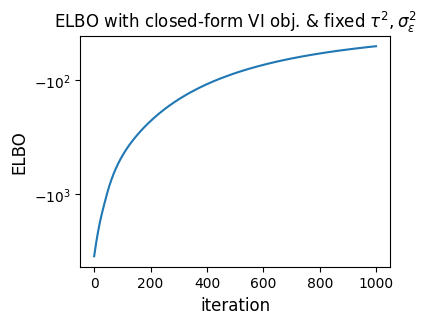

In [17]:
fig, axs = plt.subplots(1,1, figsize = (4,3))
axs.plot(elbos)
axs.set_yscale('symlog')
axs.set_title(r'ELBO with closed-form VI obj. & fixed $\tau^2, \sigma_{\varepsilon}^2$')
axs.set_xlabel('iteration', size = 12)
axs.set_ylabel('ELBO', size = 12)

## 4. Predictions
Compute the predictive mean and standard deviation using
\begin{align}
p(y | x, \mu_w, \tau^2) = \mathcal{N}(\mu_w^T\psi, \psi^T \Sigma_w \psi + \sigma_{\varepsilon}^2I).
\end{align}

In [18]:
X_test = torch.linspace(-10,10, 300).unsqueeze(1)
Psi_test = lli_net.get_ll_embedd(X_test)
pred_mean = (Psi_test @  last_layer_vi.mu.T).detach().numpy().squeeze()
L  = last_layer_vi.get_L()
Z = Psi_test @ L.squeeze()  
pred_std = torch.sqrt((Z ** 2).sum(dim=1) + sigma_eps_sq).detach().numpy()

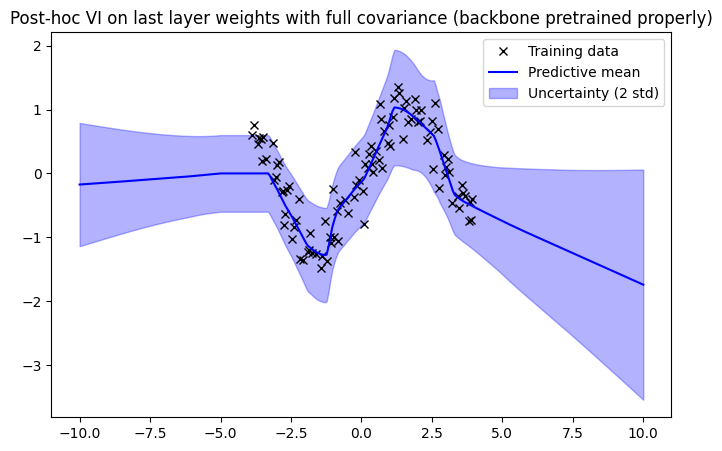

In [19]:
plt.figure(figsize=(8,5))
#plt.ylim(-2,2)
plt.plot(xs_train.numpy(), ys_train.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), pred_mean, 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 pred_mean - 2 * pred_std,
                pred_mean + 2 * pred_std,
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with full covariance (backbone pretrained properly)")
plt.show()

# Ridge

We now want to perform the same estimation, but with a more sophisticated model: a hierarchical model with a ridge prior.
We now equip both $\tau^2$ and $\sigma_{\varepsilon}^2$ with inverse-gamma priors. 
Before, we merely guessed their values - or "cheated" a bit because we used the true value of $\sigma_{\varepsilon}^2$.
Equipping both variances with priors protects us from severe misspecification of these values.

We now have
\begin{align}
\tau^2 \sim  \mathcal{IG}(a_\tau, b_{\tau}) \qquad \sigma_{\varepsilon}^2 \sim \mathcal{IG}(a_\sigma, b_{\sigma}),
\end{align}
where $a_\tau > 0 $ ($a_\sigma$) is the shape and $b_{\tau} > 0$ ($b_{\sigma}$) is the scale. To get an "uninformative" prior, we can set $a = 2, b=2$.
It's obvious, that our misspeficiation now merely moved one layre up in the hierarchy. We could of course still very much choose "bad" values of $a,b$. But these will have a smaller influence then directly misspecifying $\tau^2, \sigma_{\varepsilon}^2$.

Our variational distribution now has two additional parameters: $\log(\tau^2), \log(\sigma_{\varepsilon}^2)$. We need to reparameterize them with logarithms because the normal distribution can take on pos. and neg. values - but the variances are only positive.

Our ELBO now looks a bit different then before. We still have the expected log-likelihood but several KL terms for our different priors:
\begin{align}
\text{ELBO}(\lambda) = \textcolor{purple}{E_{q_\lambda}[\log p(y \mid x, w, \tau^2, \sigma_{\varepsilon}^2)]} - \textcolor{green}{\mathbb{E}_{q_\lambda}[KL(q_{\lambda}(w) || p(w | \tau^2))]} - \textcolor{red}{KL( q_{\lambda}(\tau^2) || p(\tau^2))} - \textcolor{blue}{KL( q_{\lambda}(\sigma_{\varepsilon}^2) || p(\sigma_{\varepsilon}^2))}
\end{align}
We now only use a diagonal covariance matrix in the variational density $q$.

Let's again set up our LastLayerVI class.

In [8]:
for param in lli_net.parameters():
    param.requires_grad = False

with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)


class LastLayerVI(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.log_tau_sq = nn.Parameter(torch.ones(out_features, 1))
        self.log_sigma_eps_sq = nn.Parameter(torch.ones(out_features, 1))

        self.Sigma_q_unconstrained = nn.Parameter(torch.randn(out_features, in_features + 2) * 0.01)
    
    def get_tau_sq(self):
        return torch.nn.functional.exp(self.log_tau_sq)
    
    def get_sigma_eps_sq(self):
        return torch.nn.functional.exp(self.log_sigma_eps_sq)

    def get_Sigma_q(self):
        Sigma_q = torch.nn.functional.softplus(self.Sigma_q_unconstrained) + 1e-5
        return Sigma_q
    
    def forward(self, X, S = 5):
        # sample 
        params = torch.cat([self.mu, self.log_tau_sq, self.log_sigma_eps_sq], dim = -1 )
        eps = torch.randn(S, params.shape[1])  
        Sigma_q = self.get_Sigma_q()
        params_samples = params + L*eps

        y_sample = X @ params_samples[:, :self.in_features].t()
        
        return params_samples, params, y_sample, Sigma_q
    
    def forward_sample(self, X, S = 1):
        # sample 
        params = torch.cat([self.mu, self.log_tau_sq, self.log_sigma_eps_sq], dim = -1 )
        eps = torch.randn(S, params.shape[1])  
        L = self.get_Sigma_q()
        params_samples = params + L*eps
        w_sample = params_samples[:, :self.in_features]

        y_sample = X @ w_sample.T # variance is missing here
        
        return y_sample

In [9]:
last_layer_vi = LastLayerVI(in_features=Psi.shape[1], out_features=1)
optimizer_vi = Adam(last_layer_vi.parameters(), lr=1e-3)
num_epochs = 30000
sigma_eps_sq = sigma_eps**2
N, L = Psi.shape

In [11]:
def kl_w_vectorized(mu, Sigma_q, tau_sq_samples):
    _, L = mu.shape

    logdet_Sigma = torch.sum(torch.log(Sigma_q), dim=1)
    trace_term = torch.sum(Sigma_q, dim=1)              
    mu_norm_sq = torch.sum(mu**2, dim=1)                
    log_tau_sq = torch.log(tau_sq_samples)               

    kl = 0.5 * (trace_term / tau_sq_samples + mu_norm_sq / tau_sq_samples - L + L * log_tau_sq - logdet_Sigma)

    return kl.mean()

def kl_tau_sq(q_log_pdf_normal_value, tau_sq_samples, a_tau, b_tau):
    log_prior_ig = (
        a_tau * torch.log(torch.tensor(b_tau)) 
        - torch.lgamma(torch.tensor(a_tau))
        - (a_tau + 1) * torch.log(tau_sq_samples) 
        - b_tau / tau_sq_samples
    )
    
    kl = q_log_pdf_normal_value.mean() - log_prior_ig.mean()
    return kl

def q_log_pdf_lognormal(sigma_eps_sq_samples, mu_log, log_var_log):

    var_log = torch.exp(log_var_log)
    log_x = torch.log(sigma_eps_sq_samples)
    log_pdf = (
        - log_x
        - 0.5 * torch.log(2 * torch.pi * var_log)
        - (log_x - mu_log)**2 / (2 * var_log)
    )
    return log_pdf

def log_p_sigma_eps_sq_ig(sigma_eps_sq, a_sigma, b_sigma):
    log_prob1 = a_sigma * math.log(b_sigma) - gammaln(a_sigma)
    log_prob2 = -(a_sigma + 1) * torch.log(sigma_eps_sq) - b_sigma / sigma_eps_sq
    return log_prob1 + log_prob2  # shape [S]

def kl_sigma_eps_sq(q_log_pdf, sigma_eps_sq_samples, a_sigma, b_sigma):
    log_prior = log_p_sigma_eps_sq_ig(sigma_eps_sq_samples, a_sigma, b_sigma)
    return (q_log_pdf - log_prior).mean()

In [13]:
elbos = []
for epoch in range(num_epochs):
    optimizer_vi.zero_grad()
    
    params_samples, params, y_sample, Sigma_q = last_layer_vi.forward(Psi)

    # samples of parameters
    w_samples =  params_samples[:, :last_layer_vi.in_features]
    sigma_eps_sq_samples = torch.exp(params_samples[:, -1]) + 1e-5
    tau_sq_samples = torch.exp(params_samples[:, -2]) + 1e-5

    # variational means
    q_w_mu = params[:, :last_layer_vi.in_features]
    q_log_tau_sq_mu = params_samples[:, -2]
    q_log_sigma_eps_sq_mu = params_samples[:, -1]

    q_log_sigma_eps_sq_var = Sigma_q[:, -1]
    q_log_tau_sq_var = Sigma_q[:, -2]

    # likelihood
    log_likelihood = (
        - 0.5 * N * torch.log(sigma_eps_sq_samples) 
        - 0.5 * (torch.sum((ys_train - y_sample) ** 2)/ sigma_eps_sq_samples))
    
    # expected KL
    kl_w = kl_w_vectorized(w_samples, Sigma_q[:,:last_layer_vi.in_features], tau_sq_samples)
    q_log_pdf_normal_value_eps = q_log_pdf_lognormal(sigma_eps_sq_samples, q_log_sigma_eps_sq_mu, q_log_sigma_eps_sq_var)
    
    kl_sigma_eps_sq_value = kl_sigma_eps_sq(q_log_pdf_normal_value_eps, sigma_eps_sq_samples, 2, 2)
    q_log_pdf_normal_value_tau_value = q_log_pdf_lognormal(tau_sq_samples, q_log_tau_sq_mu, q_log_tau_sq_var)
    kl_tau_sq_value = kl_tau_sq(q_log_pdf_normal_value_tau_value, tau_sq_samples, 2, 2)
    
    elbo = (
        log_likelihood.mean() 
        - kl_w - kl_sigma_eps_sq_value - kl_tau_sq_value
    )
    loss = -elbo
    loss.backward()
    optimizer_vi.step()
    if epoch % 1000 == 0:
        print(f"VI epoch {epoch} ELBO: {elbo.item():.3f}")

    elbos.append(elbo.item())

VI epoch 0 ELBO: -2172689920.000
VI epoch 1000 ELBO: -1390001280.000
VI epoch 2000 ELBO: -133631536.000
VI epoch 3000 ELBO: -1245095680.000
VI epoch 4000 ELBO: -2391.257
VI epoch 5000 ELBO: -3779545856.000
VI epoch 6000 ELBO: -277520.625
VI epoch 7000 ELBO: -33399.059
VI epoch 8000 ELBO: -1475691.750
VI epoch 9000 ELBO: -31984.156
VI epoch 10000 ELBO: -1084458.000
VI epoch 11000 ELBO: -5559232.500
VI epoch 12000 ELBO: -570880192.000
VI epoch 13000 ELBO: -7941422080.000
VI epoch 14000 ELBO: -10366060544.000
VI epoch 15000 ELBO: -675289856.000
VI epoch 16000 ELBO: -4058359.000
VI epoch 17000 ELBO: -44522.262
VI epoch 18000 ELBO: -10357640.000
VI epoch 19000 ELBO: -898132416.000
VI epoch 20000 ELBO: -919356.438
VI epoch 21000 ELBO: -38751.020
VI epoch 22000 ELBO: -118361.031
VI epoch 23000 ELBO: -11951154.000
VI epoch 24000 ELBO: -5782057.000
VI epoch 25000 ELBO: -5922085.000
VI epoch 26000 ELBO: -57779.488
VI epoch 27000 ELBO: -68071712.000
VI epoch 28000 ELBO: -27522906.000
VI epoch 290

We are now numerically estimating $\mathbb{E}_{q_{\lambda}}$, so our ELBO looks a bit more noisy.

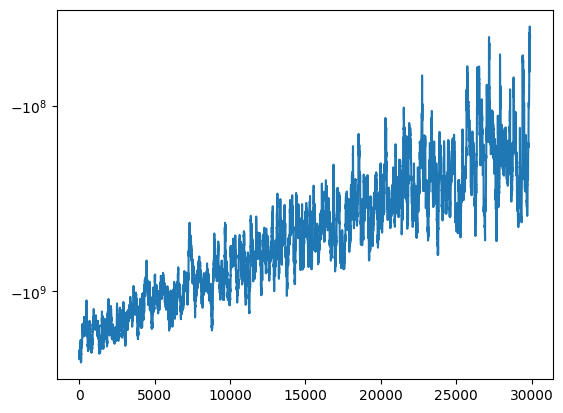

In [35]:
plt.plot(sliding_window_view(elbos, 100).mean(axis=1))
plt.yscale('symlog')

See "Variational Relevance Vector Machines" by Bishop, Tipping (2000, UAI), Eq.~35-38. Note that our $\tau^2$ is $\alpha^{-1}$ there. And their $\tau$ is our $\sigma_{\varepsilon}^2$.

The pred. posterior is approx. normal.
This also directly transfers to the horseshoe (bc in Bishop, Tipping $\alpha$ is a vector with a different shrinkage element for each $w_l$, $l = 1, \ldots L$.

In [26]:
X_test = torch.linspace(-10,10, 300).unsqueeze(1)
Psi_test = lli_net.get_ll_embedd(X_test)
pred_mean = (Psi_test @  last_layer_vi.mu.T).detach().numpy().squeeze()
Sigma_q  = last_layer_vi.get_Sigma_q().squeeze()
Z = torch.diag(Psi_test @ torch.diag(Sigma_q[:L]) @ Psi_test.T)
pred_std = torch.sqrt(Z + sigma_eps_sq).detach().numpy()

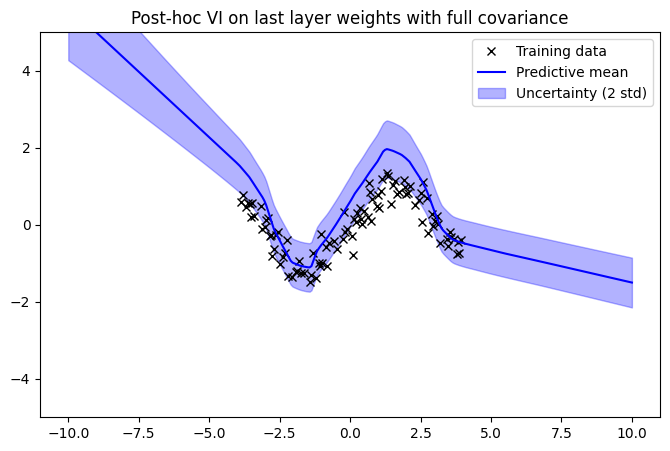

In [32]:
plt.figure(figsize=(8,5))
plt.ylim(-5,5)
plt.plot(xs_train.numpy(), ys_train.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), pred_mean, 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 pred_mean - 2 * pred_std,
                pred_mean + 2 * pred_std,
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with full covariance")
plt.show()


# Horseshoe
For the horseshoe prior we have a separate variance parameter $\tau_l^2$ for each weight $w_l$ resulting in for $l = 1, \ldots, L$. Each variance parameter follows an inverse-gamma distribution
\begin{align}
\tau_l^2  \sim \mathcal{HC}(0, 1)
\end{align}
Technically the horseshoe also has a global shrinkage component, but we just set this to 1. 

We only have to make some minor changes to the ELBO to integrate the horseshoe prior:

\begin{align}
\text{ELBO}(\lambda) = E_{q_\lambda}[\log p(y \mid x, w, \textcolor{red}{\tau_1^2, \ldots \tau_L^2}, \sigma_{\varepsilon}^2)] -\mathbb{E}_{q_\lambda}[KL(q_{\lambda}(w) || p(w |\textcolor{red}{\tau_1^2, \ldots, \tau_L^2}))] - KL( q_{\lambda}(\tau^2) || p(\tau^2 )) -  - KL( q_{\lambda}(\sigma_{\varepsilon}^2) || p(\sigma_{\varepsilon}^2))
\end{align}

We need to update the log-likelihood, and one two KL divergences.

In [13]:
class LastLayerVIHorseshoe(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.log_lambda_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.log_sigma_eps_sq_mu = nn.Parameter(torch.zeros(out_features, 1))

        total_dim = in_features + in_features + 1
        self.Sigma_q_unconstrained = nn.Parameter(
            torch.randn(out_features, total_dim) * 0.01
        )
    
    def get_sigma_eps_sq(self):
        return torch.exp(self.log_sigma_eps_sq_mu)

    def get_Sigma_q(self):
        return torch.nn.functional.softplus(self.Sigma_q_unconstrained) + 1e-5
    
    def forward(self, X, S=5):

        params = torch.cat([self.mu, self.log_lambda_mu, self.log_sigma_eps_sq_mu], dim=-1)
        
        eps = torch.randn(S, params.shape[1], device=params.device)
        Sigma_q = self.get_Sigma_q()
        params_samples = params + Sigma_q * eps

        w_samples = params_samples[:, :self.in_features]
        y_sample = X @ w_samples.T
        
        return params_samples, params, y_sample, Sigma_q
    
    def forward_sample(self, X, S=1):
        params = torch.cat([self.mu, self.log_lambda_mu, self.log_sigma_eps_sq_mu], dim=-1)
        eps = torch.randn(S, params.shape[1], device=params.device)
        Sigma_q = self.get_Sigma_q()
        params_samples = params + Sigma_q * eps
        
        w_samples = params_samples[:, :self.in_features]
        y_sample = X @ w_samples.T
        return y_sample


In [14]:
last_layer_vi_hs = LastLayerVIHorseshoe(in_features=Psi.shape[1], out_features=1)
optimizer_vi = Adam(last_layer_vi_hs.parameters(), lr=1e-3)
num_epochs = 10000
sigma_eps_sq = sigma_eps**2
N, L = Psi.shape

In [15]:
elbos = []
for epoch in range(num_epochs):
    optimizer_vi.zero_grad()
    
    # Forward pass: sample params from variational distribution
    params_samples, params, y_sample, Sigma_q = last_layer_vi_hs.forward(Psi)

    # Extract samples of parameters
    w_samples = params_samples[:, :last_layer_vi_hs.in_features]  # shape [S, p]
    sigma_eps_sq_samples = torch.exp(params_samples[:, -1]) + 1e-5  # [S]
    # Local scale samples λ_j (log λ_j ~ Normal(m_j, s_j^2))
    lambda_samples = torch.exp(params_samples[:, last_layer_vi_hs.in_features:-1]) + 1e-8  # [S, p]

    # Variational means/vars
    q_w_mu = params[:, :last_layer_vi_hs.in_features]  # [S, p]
    q_lambda_mu = params[:, last_layer_vi_hs.in_features:-1]  # mean of log λ_j
    q_lambda_var = Sigma_q[:, last_layer_vi_hs.in_features:-1]  # var of log λ_j

    q_log_sigma_eps_sq_mu = params_samples[:, -1]
    q_log_sigma_eps_sq_var = Sigma_q[:, -1]

    # Likelihood term E_q[ log p(y | x, w, σ^2) ]
    log_likelihood = (
        -0.5 * N * torch.log(sigma_eps_sq_samples.unsqueeze(0))
        -0.5 * (ys_train - y_sample) ** 2 / sigma_eps_sq_samples.unsqueeze(0))
  # shape [S]
    ll_term = log_likelihood.sum(dim=0).mean()

    # KL term for w: E_q[ KL(q(w) || p(w | λ)) ]
    # Gaussian-Gaussian KL, averaged over λ samples
    # Σ_q_diag = variances of q_w
    Sigma_w_diag = Sigma_q[:, :last_layer_vi_hs.in_features]  # [S, p]
    # Expectations: λ^{-2} and log λ^2
    E_inv_lambda_sq = torch.exp(-2 * q_lambda_mu + 2 * q_lambda_var)  # analytic
    E_log_lambda_sq = 2 * q_lambda_mu
    kl_w = 0.5 * torch.sum(
        (Sigma_w_diag.mean(dim=0) + q_w_mu.mean(dim=0)**2) * E_inv_lambda_sq.mean(dim=0)
        - 1
        + E_log_lambda_sq.mean(dim=0)
        - torch.log(Sigma_w_diag.mean(dim=0) + 1e-8)
    )

    # KL term for λ_j: KL(q(λ_j) || p(λ_j)), p(λ_j) = half-Cauchy(0,1)
    # Monte Carlo estimate
    q_log_pdf_lambda = q_log_pdf_lognormal(lambda_samples, q_lambda_mu, q_lambda_var)
    log_p_lambda = math.log(2.0 / math.pi) - torch.log(1.0 + lambda_samples**2)
    kl_lambda = torch.sum((q_log_pdf_lambda - log_p_lambda).mean(dim=0))  # sum over j

    # KL term for σ^2: KL(q(σ_ε^2) || p(σ_ε^2))
    q_log_pdf_sigma_eps = q_log_pdf_lognormal(sigma_eps_sq_samples,
                                              q_log_sigma_eps_sq_mu,
                                              q_log_sigma_eps_sq_var)
    
    q_log_pdf_normal_value_eps = q_log_pdf_lognormal(sigma_eps_sq_samples, q_log_sigma_eps_sq_mu, q_log_sigma_eps_sq_var)
    kl_sigma_eps_sq_value = kl_sigma_eps_sq(q_log_pdf_normal_value_eps, sigma_eps_sq_samples, 2, 2)

    # ELBO
    elbo = ll_term - kl_w - kl_lambda - kl_sigma_eps_sq_value
    loss = -elbo

    loss.backward()
    optimizer_vi.step()

    if epoch % 100== 0:
        print(f"VI epoch {epoch} ELBO: {elbo.item():.3f}")

    elbos.append(elbo.item())


VI epoch 0 ELBO: -1131.981
VI epoch 100 ELBO: 2062.477
VI epoch 200 ELBO: 125.977
VI epoch 300 ELBO: 1142.559
VI epoch 400 ELBO: 3627.274
VI epoch 500 ELBO: 1542.515
VI epoch 600 ELBO: 2418.313
VI epoch 700 ELBO: 5920.010
VI epoch 800 ELBO: 3086.769
VI epoch 900 ELBO: 4026.881
VI epoch 1000 ELBO: 5440.363
VI epoch 1100 ELBO: 5746.101
VI epoch 1200 ELBO: 7228.801
VI epoch 1300 ELBO: 6148.156
VI epoch 1400 ELBO: 3967.465
VI epoch 1500 ELBO: 8385.855
VI epoch 1600 ELBO: 9346.343
VI epoch 1700 ELBO: 7822.567
VI epoch 1800 ELBO: 8424.598
VI epoch 1900 ELBO: 7831.935
VI epoch 2000 ELBO: 9196.459
VI epoch 2100 ELBO: 8929.589
VI epoch 2200 ELBO: 13893.762
VI epoch 2300 ELBO: 11826.944
VI epoch 2400 ELBO: 13545.512
VI epoch 2500 ELBO: 11919.447
VI epoch 2600 ELBO: 13553.305
VI epoch 2700 ELBO: 13010.286
VI epoch 2800 ELBO: 14898.553
VI epoch 2900 ELBO: 15822.443
VI epoch 3000 ELBO: 13543.665
VI epoch 3100 ELBO: 16087.589
VI epoch 3200 ELBO: 16752.789
VI epoch 3300 ELBO: 15259.505
VI epoch 3400 

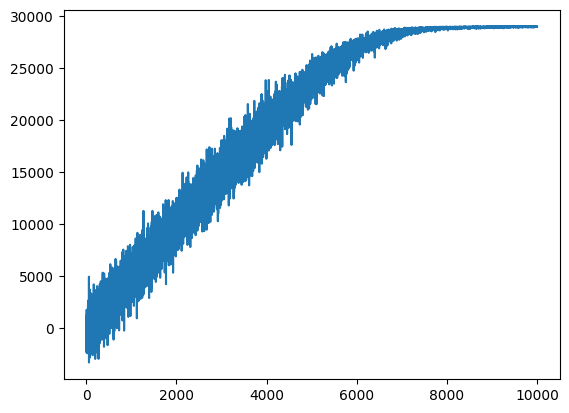

In [16]:
plt.plot(elbos)

In [17]:
X_test = torch.linspace(-10,10, 300).unsqueeze(1)
Psi_test = lli_net.get_ll_embedd(X_test)
pred_mean = (Psi_test @  last_layer_vi_hs.mu.T).detach().numpy().squeeze()
Sigma_q  = last_layer_vi_hs.get_Sigma_q().squeeze()
Z = torch.diag(Psi_test @ torch.diag(Sigma_q[:L]) @ Psi_test.T)
pred_std = torch.sqrt(Z + sigma_eps_sq).detach().numpy()

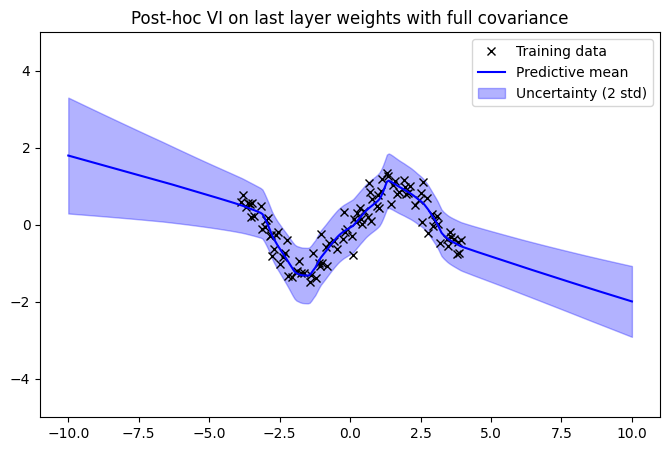

In [18]:
plt.figure(figsize=(8,5))
plt.ylim(-5,5)
plt.plot(xs_train.numpy(), ys_train.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), pred_mean, 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 pred_mean - 2 * pred_std,
                pred_mean + 2 * pred_std,
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with full covariance")
plt.show()

# Ridge + FullCov

use:
q_z = LowRankMultivariateNormal(
                loc=z_mu.to(self.device_LowRankNormal),
                cov_factor=z_cov_factor.to(self.device_LowRankNormal),
                cov_diag=z_cov_sigma.to(self.device_LowRankNormal),
            )

@staticmethod
    def get_num_el_r(z_dim: int, rank_B: int) -> int:
        """Compute the number of elements needed
        for the covarince matrix based on the number of factors
        (rank_B) and dimension of z (z_dim).
        The covariance matrix is Sigma = B.dot(B.t()) + D**2
        where B is z_dim x rank_B with rank_B << z_dim.
        D is a diagonal matrix with z_dim elements"""

        # grab lower diagonal indices
        tril_indices = torch.tril_indices(row=z_dim, col=rank_B, offset=-1)
        num_elements = tril_indices.size(1)

        return num_elements + z_dim

In [ ]:
for param in lli_net.parameters():
    param.requires_grad = False

with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)


class LastLayerVIRidgeFullCov(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.log_tau_sq = nn.Parameter(torch.ones(out_features, 1))
        self.log_sigma_eps_sq = nn.Parameter(torch.ones(out_features, 1))

        # here need triang. factors B and diagonal elements d
        # can use q_z = LowRankMultivariateNormal(
        #        loc=z_mu.to(self.device_LowRankNormal),
        #        cov_factor=z_cov_factor.to(self.device_LowRankNormal),
        #        cov_diag=z_cov_sigma.to(self.device_LowRankNormal),
        #    )
        self.Sigma_q_unconstrained = nn.Parameter(torch.randn(out_features, in_features + 2) * 0.01)
    
    def get_tau_sq(self):
        return torch.nn.functional.exp(self.log_tau_sq)
    
    def get_sigma_eps_sq(self):
        return torch.nn.functional.exp(self.log_sigma_eps_sq)

    def get_Sigma_q(self):
        # here need to compute BB^T + D
        Sigma_q = torch.nn.functional.softplus(self.Sigma_q_unconstrained) + 1e-5
        return Sigma_q
    
    def forward(self, X, S = 5):
        # sample 
        params = torch.cat([self.mu, self.log_tau_sq, self.log_sigma_eps_sq], dim = -1 )
        eps = torch.randn(S, params.shape[1])  
        # here need to pay attention how we sample -> decomp. of Sigma_q to draw samples
        Sigma_q = self.get_Sigma_q()
        params_samples = params + Sigma_q*eps

        y_sample = X @ params_samples[:, :self.in_features].t()
        
        return params_samples, params, y_sample, Sigma_q

In [ ]:
last_layer_vi = LastLayerVIRidgeFullCov(in_features=Psi.shape[1], out_features=1)
optimizer_vi = Adam(last_layer_vi.parameters(), lr=1e-3)
num_epochs = 30000
sigma_eps_sq = sigma_eps**2
N, L = Psi.shape

In [ ]:
elbos = []
for epoch in range(num_epochs):
    optimizer_vi.zero_grad()
    
    params_samples, params, y_sample, Sigma_q = last_layer_vi.forward(Psi)

    # samples of parameters
    w_samples =  params_samples[:, :last_layer_vi.in_features]
    sigma_eps_sq_samples = torch.exp(params_samples[:, -1]) + 1e-5
    tau_sq_samples = torch.exp(params_samples[:, -2]) + 1e-5

    # variational means
    q_w_mu = params[:, :last_layer_vi.in_features]
    q_log_tau_sq_mu = params_samples[:, -2]
    q_log_sigma_eps_sq_mu = params_samples[:, -1]

    # add variance matrix for w
    # can stay as is
    q_log_sigma_eps_sq_var = Sigma_q[:, -1]
    q_log_tau_sq_var = Sigma_q[:, -2]

    # likelihood
    log_likelihood = (
        - 0.5 * N * torch.log(sigma_eps_sq_samples) 
        - 0.5 * (torch.sum((ys_train - y_sample) ** 2)/ sigma_eps_sq_samples))
    
    # expected KL
    # here need to index Sigma_q differently, make sure it's a full matrix
    kl_w = kl_w_vectorized(w_samples, Sigma_q[:,:last_layer_vi.in_features], tau_sq_samples)
    q_log_pdf_normal_value_eps = q_log_pdf_lognormal(sigma_eps_sq_samples, q_log_sigma_eps_sq_mu, q_log_sigma_eps_sq_var)
    
    kl_sigma_eps_sq_value = kl_sigma_eps_sq(q_log_pdf_normal_value_eps, sigma_eps_sq_samples, 2, 2)
    q_log_pdf_normal_value_tau_value = q_log_pdf_lognormal(tau_sq_samples, q_log_tau_sq_mu, q_log_tau_sq_var)
    kl_tau_sq_value = kl_tau_sq(q_log_pdf_normal_value_tau_value, tau_sq_samples, 2, 2)
    
    elbo = (
        log_likelihood.mean() 
        - kl_w - kl_sigma_eps_sq_value - kl_tau_sq_value
    )
    loss = -elbo
    loss.backward()
    optimizer_vi.step()
    if epoch % 1000 == 0:
        print(f"VI epoch {epoch} ELBO: {elbo.item():.3f}")

    elbos.append(elbo.item())